<a href="https://colab.research.google.com/github/zdzichumis/Object-tracking-code/blob/main/analiza_wyniki.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

In [6]:
def check_if_inside(point, bbox):
    bx0, by0, bx1, by1 = bbox
    x, y = point
    return (bx0 <= x <= bx1) and (by0 <= y <= by1)

In [7]:
tracking_bbox = pd.read_csv("track_04_30_18h_18.csv")
true_points = pd.read_csv("tagged2min_04_30_18h_18.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'track_04_30_18h_18.csv'

## ograniczanie danych

#### do obszaru zainteresowania na czerwono

In [4]:
main_area = [(0,720), (75, 288), (166,243), (1015,200), (1082, 241),
(1207, 512), (1065, 720)]

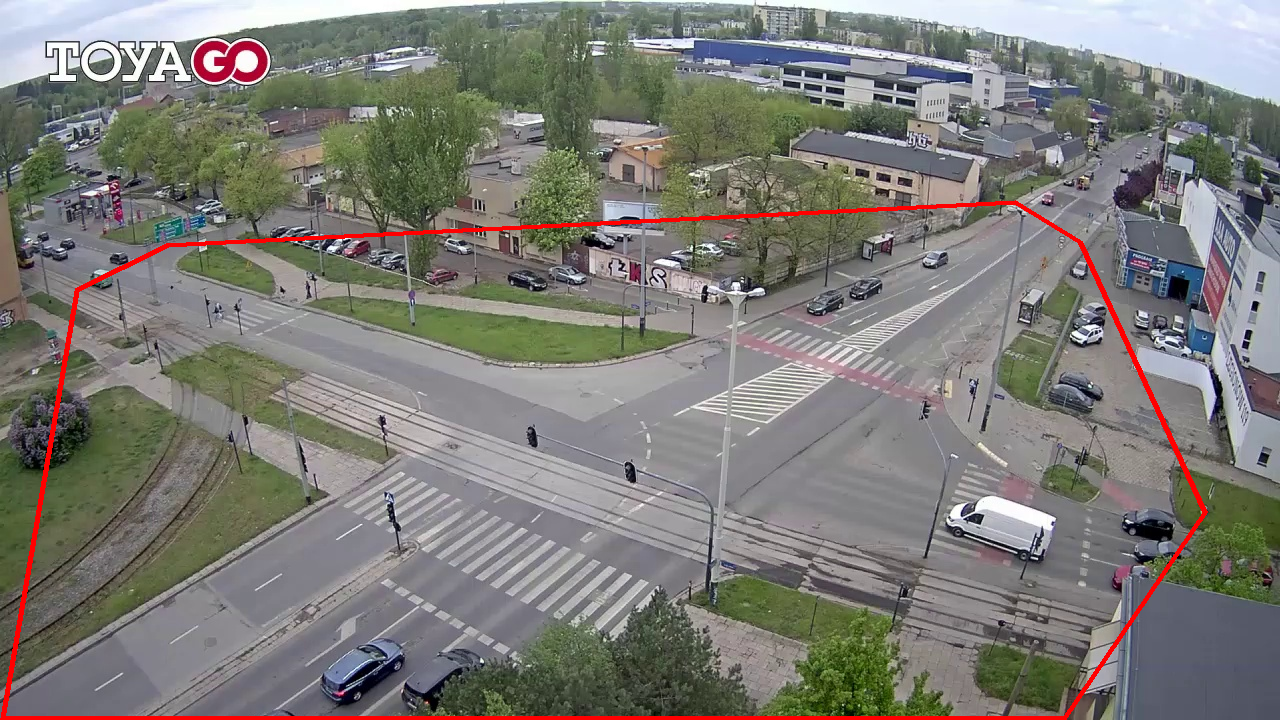

In [ ]:
img = Image.open("reference.jpg")
img1 = ImageDraw.Draw(img)
img1.polygon(main_area, outline ="red", width=5)
img

$$ta+(1-t)b = (c_x, \cdot)$$

$$b+t(a-b) = (c_x, \cdot)$$

$$t^\ast = \frac{c_x-b_x}{a_x-b_x}, \ t^\ast(a-b) + b > c_y$$

In [ ]:
def is_inner(px,py):
    points = main_area + [main_area[0]]
    counter = 0
    for a,b in zip(points, points[1:]):
        ax, ay = a
        bx, by = b
        t = (px - bx)/(ax - bx)
        if 0 <= t < 1 and t * (ay - by) + by >= py:
            counter += 1
    return (counter % 2) != 0


In [ ]:
#####
#####  TAKES TRUE POINTS ONLY FROM INSIDE THE AREA OF INTEREST
#####

true_points = true_points[true_points.apply(lambda row: is_inner(row["x"], row["y"]), axis=1)]

#### do pierwszych dwóch minut

In [ ]:
#####
#####  TAKES ONLY FRAMES FROM THE FIRST TWO MINUTES
#####

true_points = true_points[true_points["frame"] <= 30*60*2]
tracking_bbox = tracking_bbox[tracking_bbox["frame"] <= 30*60*2]

## Obliczenie metryk poprawności śledzenia

In [ ]:
#calculate if point is inside a bbox
#(the true points are not always perfectly on the car, so I use `eps` to be more forgiving)
matching = pd.merge(true_points, tracking_bbox, on="frame", suffixes=("_true", "_pred"))
match_x = ((matching["x0"] <= matching["x"]) & (matching["x"] <= matching["x1"] ))
match_y = ((matching["y0"] <= matching["y"]) & (matching["y"] <= matching["y1"]))
matching = matching[match_x & match_y]
matched = matching.copy().drop(columns=["x0","y0","x1", "y1"])

Definicje metryk:
 * `(%) matches best` - jaka część punktów pojazdu została przydzielona do obiektu (ze śledzenia), przy czym wybieramy obiekt dla któego ta część jak największa. Metryka powinna być jak największa, ale nie musi być 100%, bo brak detekcji samochodu również ma na nią wpływ.
 * `(%) matches 2nd best` - tak samo jak wyżej, tylko biorę drugi najlepszy obiekt. Metryka powinny być jak najmniejsza. Brak detekcji samochodu nie wypływa negatywnie na metrykę.
 * `(%) nondominant matches` -  podobnie jak `(%) matches best` tylko sumuje metryki dla wszystkich obiektów innych niż najlepszy (tzn. inne niż te używane w `(%) matches best`).

In [ ]:
def check_true_object_i(label_i):
    points_count = true_points["label"].value_counts()[label_i]
    time_matched = matched[matched["label_true"]== label_i]["label_pred"].value_counts()/points_count*100
    remaining = 0
    if len(time_matched) > 0:
        remaining = time_matched.sum() - float(time_matched.head(1))
    time_matched = time_matched.head(2)
    return (list(time_matched) + [0, 0])[:2] + [remaining]
object_metrics = pd.DataFrame([check_true_object_i(y) + [y]
                           for y in true_points["label"].unique()],
            columns = ["(%) matches best", "(%) matches 2nd best", "(%) nondominant matches", "true_object_id"])
object_metrics.head(5)

,(%) matches best,(%) matches 2nd best,(%) nondominant matches,true_object_id
0,99.408284,35.502959,55.621302,0
1,79.775281,11.797753,13.483146,1
2,73.275862,7.758621,7.758621,2
3,44.366197,40.845070,44.366197,3
4,31.428571,17.142857,31.428571,4


In [ ]:
object_metrics

,(%) matches best,(%) matches 2nd best,(%) nondominant matches,true_object_id
0,99.408284,35.502959,55.621302,0
1,79.775281,11.797753,13.483146,1
2,73.275862,7.758621,7.758621,2
3,44.366197,40.845070,44.366197,3
4,31.428571,17.142857,31.428571,4
5,46.153846,30.769231,38.461538,5
6,34.020619,2.061856,2.061856,6
7,50.000000,36.144578,80.722892,7
8,74.074074,33.333333,37.037037,8
9,100.000000,3.448276,6.896552,9


In [ ]:
object_metrics.mean()

(%) matches best           43.305941
(%) matches 2nd best        7.218283
(%) nondominant matches    11.471262
true_object_id             23.106383
dtype: float64

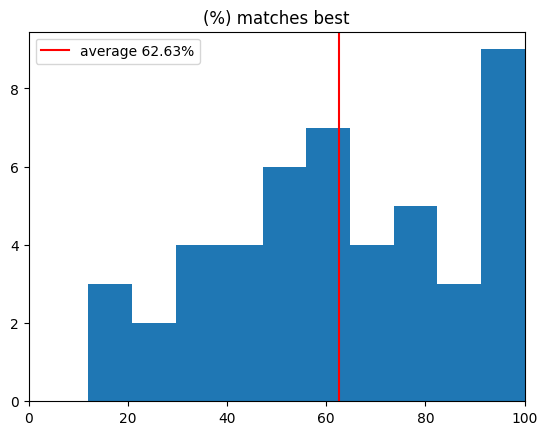

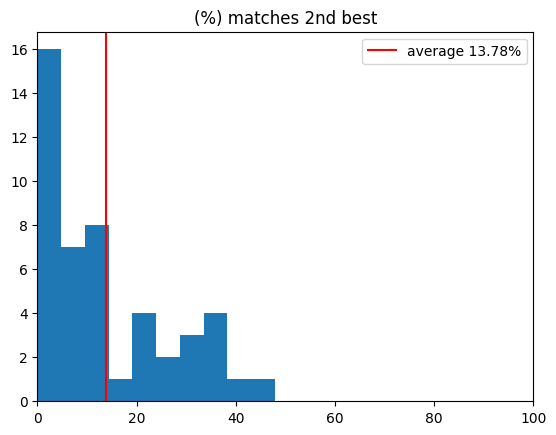

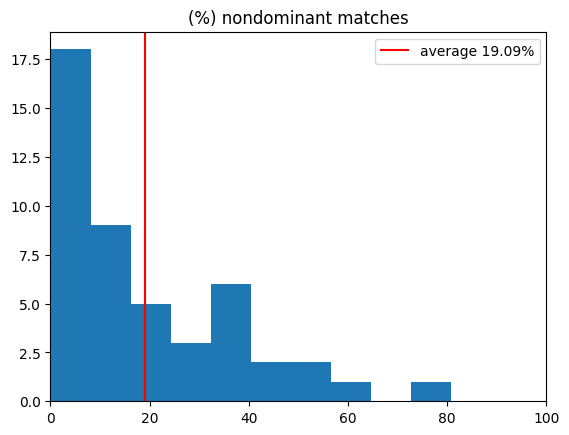

In [ ]:
for i, col in enumerate(["(%) matches best", "(%) matches 2nd best", "(%) nondominant matches"]):
    plt.hist(object_metrics[col])
    avg =object_metrics[col].mean()
    plt.title(col)
    plt.axvline(x=avg, ymin=0, ymax=1, color="red", label=f"average {avg:.4}%")
    plt.xlim(0, 100)
    plt.legend()
    plt.show()

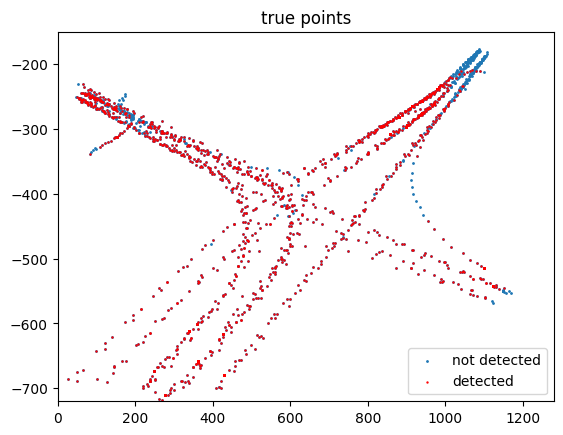

In [ ]:
def check(tp, match):
    plt.title("true points")
    plt.scatter(tp["x"], (-1)*tp["y"], s=1, label="not detected")
    plt.scatter(match["x"], (-1)*match["y"], s=0.5, color="red", label="detected")
    plt.xlim(0, 1280)
    plt.ylim(-720,-150)
    plt.legend()
check(true_points, matching)
#check(true_points[true_points["label"] == 29],
#      matching[matching["label_true"] == 29])